Imports

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
%matplotlib inline

Read Data

In [219]:
file = pd.ExcelFile("../../data/final/Handball_09.03.2023_fertig.xlsx")

file.sheet_names

df = file.parse('3. League')

# drop last col comments & favorite corner & empy rows at end
df = df.iloc[:, :-2]
df.columns


Index(['Home team', 'Guest team', 'Matchday', 'Player 3rd league',
       'Shooter team', 'club region', 'Game Minute',
       'Difference between\nfinal whistle and kickoff \n(in seconds)',
       'Home Goal', 'Guest Goal',
       'Goalkeeper position\n(0 = on the line;\n 1 = in front of the line)',
       'Toss successful?\n(0 = no; 1 = yes;\n 2 = yes, afterthrow',
       'Left/right \nhanded?\n(1 = right; 2 = left)', 'Throw direction',
       'Pressure situation?\n(0 = no; \n1= Goalkeeper change;\n2 = last 7 meter held; 3 = goal difference < 4 + from 50. minute; 4 = 1+2; 5 = 1+3; 6 = 2+3; 7 = 1+2+3; 8 = last 7 meter successful in follow-up throw\n',
       'Number of seven meters\n(of the player)',
       'Throw quadrant last 7 meter',
       'last 7 meter successful?\n(0 = no; 1 = yes; \n2 = yes, in the afterthrow'],
      dtype='object')

Cleanup & Renaming

In [220]:
df.replace('unklar', np.nan,inplace=True)
df.replace('unklar ', np.nan,inplace=True)
df.replace('fehlend', np.nan,inplace=True)
df.replace('-', np.nan,inplace=True)
df.replace(-99, np.nan,inplace=True)
df.replace('-99', np.nan,inplace=True)
df.replace('?', np.nan,inplace=True)
df.replace('?!', np.nan,inplace=True)
#df.dropna(inplace=True)
df.columns = [ 'homeTeam','opponentTeam','day','name','team','region','playTime',
              'whistleThrowTime','homeGoals','opponentGoals',
              'goalKeeperPosition',
              'throwSuccess','LRHandy','throwDirection',
              'pressureSituation','noOfThrowsFromPlayer',
              'throwQuadrantLastThrow','lastThrowSuccess']
df = df.astype({'homeTeam':'string', 'opponentTeam':'string','day':'float16','name':'string','team':'string','region':'string','playTime':'float16',
              'whistleThrowTime':'float16','homeGoals':'float16','opponentGoals':'float16','goalKeeperPosition':'float16',
              'throwSuccess':'float16','LRHandy':'float16','throwDirection':'float16','pressureSituation':'float16','noOfThrowsFromPlayer':'float16',
              'throwQuadrantLastThrow':'float16','lastThrowSuccess':'float16', })

df['homeTeam']=df['homeTeam'].str.rstrip()
df['opponentTeam']=df['opponentTeam'].str.rstrip()
df['team']=df['team'].str.rstrip()
df['oTeam'] = [ot if str(ht) == str(t) else ht for ht,ot,t in zip(df['homeTeam'],df['opponentTeam'],df['team'])]
df['oTeam'] = df['oTeam'].astype('string')
df

,homeTeam,opponentTeam,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,throwQuadrantLastThrow,lastThrowSuccess,oTeam
0,TV Emsdetten,ASV Hamm-Westfalen II,1.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten
1,HLZ Ahlener SG,TV Emsdetten,2.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG
2,TV Emsdetten,VfL Gladbeck,3.0,Holzner,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,NaN,1.0,VfL Gladbeck
3,TV Emsdetten,VfL Gladbeck,3.0,Holzner,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,8.0,1.0,VfL Gladbeck
4,TV Emsdetten,VfL Gladbeck,3.0,Holzner,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,3.0,1.0,VfL Gladbeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,Stralsunder HV,DHK Flensborg,19.0,Skroblien,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,NaN,NaN,DHK Flensborg
1015,Stralsunder HV,DHK Flensborg,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,4.0,1.0,DHK Flensborg
1016,Stralsunder HV,DHK Flensborg,19.0,Skroblien,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,3.0,1.0,DHK Flensborg
1017,Stralsunder HV,DHK Flensborg,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,4.0,1.0,DHK Flensborg


Data Prep

In [221]:
# Dropped less data : 'homeTeam','opponentTeam', 'throwQuadrantLastThrow','lastThrowSuccess', 

feat = df.loc[:,('day','name','team','region','playTime',
              'whistleThrowTime','homeGoals','opponentGoals',
              'goalKeeperPosition',
              'throwSuccess','LRHandy','throwDirection',
              'pressureSituation','noOfThrowsFromPlayer','oTeam'
              )].copy()

feat

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam
0,1.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten
1,2.0,<NA>,<NA>,west,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG
2,3.0,Holzner,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck
3,3.0,Holzner,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck
4,3.0,Holzner,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,Skroblien,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg
1015,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg
1016,19.0,Skroblien,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg
1017,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg


WhistleTime

Median:  [30.0]
Mean:  [32.9]
Minimum:  [11.0]
Maximum:  [55.0]
Q1:  [23.0]
Q3:  [36.0]
Fliers:  [[  3.  57.  58.  58.  58.  59.  60.  60.  61.  61.  61.  63.  65.  66.
   66.  66.  66.  67.  67.  68.  70.  72.  76.  80.  81.  83.  84.  93.
   93.  96.  99. 112. 114. 117. 128. 131. 143. 177.]]


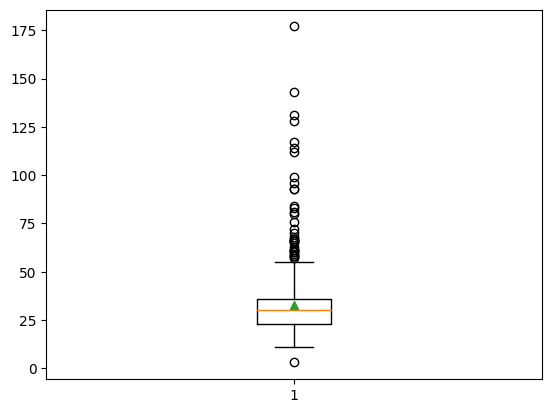

In [222]:
dfwt = feat.loc[:,('whistleThrowTime')].copy()
dfwt.dropna(inplace=True)
bp = plt.boxplot(dfwt, showmeans=True)

medians = [round(item.get_ydata()[0], 1) for item in bp['medians']]
print('Median: ',medians)
means = [round(item.get_ydata()[0], 1) for item in bp['means']]
print('Mean: ',means)
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
print('Minimum: ',minimums)
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
print('Maximum: ',maximums)
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
print('Q1: ',q1)
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
print('Q3: ',q3)
fliers = [item.get_ydata() for item in bp['fliers']]
print('Fliers: ',np.sort(fliers))

Update missing Whistle Time Column

In [223]:
#feat['whistleThrowTime'].replace( np.nan,30,inplace=True)
#feat['whistleThrowTime']

## Replaye Nan for whistleThrowTime with 0 and add it relavancy column ad binary
feat['whistleThrowTime'].replace( np.nan,0,inplace=True)
feat['whistleThrowTimeRelevant'] = [0 if time == 0 else 1 for time in feat['whistleThrowTime']]
feat

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam,whistleThrowTimeRelevant
0,1.0,<NA>,<NA>,west,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV Emsdetten,0
1,2.0,<NA>,<NA>,west,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HLZ Ahlener SG,0
2,3.0,Holzner,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck,1
3,3.0,Holzner,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck,1
4,3.0,Holzner,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,Skroblien,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg,1
1015,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1
1016,19.0,Skroblien,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg,1
1017,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1


Remove Null

In [224]:
feat.dropna(inplace=True)
feat.info()
feat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 2 to 1018
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   day                       629 non-null    float16
 1   name                      629 non-null    string 
 2   team                      629 non-null    string 
 3   region                    629 non-null    string 
 4   playTime                  629 non-null    float16
 5   whistleThrowTime          629 non-null    float16
 6   homeGoals                 629 non-null    float16
 7   opponentGoals             629 non-null    float16
 8   goalKeeperPosition        629 non-null    float16
 9   throwSuccess              629 non-null    float16
 10  LRHandy                   629 non-null    float16
 11  throwDirection            629 non-null    float16
 12  pressureSituation         629 non-null    float16
 13  noOfThrowsFromPlayer      629 non-null    float16
 14  oTeam    

,day,name,team,region,playTime,whistleThrowTime,homeGoals,opponentGoals,goalKeeperPosition,throwSuccess,LRHandy,throwDirection,pressureSituation,noOfThrowsFromPlayer,oTeam,whistleThrowTimeRelevant
2,3.0,Holzner,TV Emsdetten,west,2.0,23.0,0.0,0.0,1.0,1.0,1.0,8.0,0.0,1.0,VfL Gladbeck,1
3,3.0,Holzner,TV Emsdetten,west,7.0,16.0,5.0,1.0,1.0,1.0,1.0,3.0,0.0,2.0,VfL Gladbeck,1
4,3.0,Holzner,TV Emsdetten,west,31.0,28.0,19.0,9.0,1.0,1.0,1.0,7.0,0.0,3.0,VfL Gladbeck,1
5,3.0,Holzner,TV Emsdetten,west,51.0,22.0,31.0,20.0,1.0,1.0,1.0,1.0,0.0,4.0,VfL Gladbeck,1
6,3.0,Holzner,TV Emsdetten,west,54.0,31.0,35.0,22.0,1.0,1.0,1.0,3.0,0.0,5.0,VfL Gladbeck,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,19.0,Skroblien,Stralsunder HV,north,6.0,23.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,1.0,DHK Flensborg,1
1015,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1
1016,19.0,Skroblien,Stralsunder HV,north,49.0,36.0,28.0,22.0,1.0,0.0,1.0,3.0,0.0,3.0,DHK Flensborg,1
1017,19.0,Skroblien,Stralsunder HV,north,29.0,20.0,20.0,14.0,1.0,1.0,1.0,3.0,0.0,2.0,DHK Flensborg,1


In [225]:
# Excat info may be learned : 'day','team','region','playTime','oTeam',
# Future: 'throwSuccess',
# not much significant: 'LRHandy','noOfThrowsFromPlayer'
# included in pressure situation : 'homeGoals','opponentGoals'

feat = feat.loc[:,('name','whistleThrowTime','whistleThrowTimeRelevant','goalKeeperPosition','pressureSituation','throwDirection')]



feat

,name,whistleThrowTime,whistleThrowTimeRelevant,goalKeeperPosition,pressureSituation,throwDirection
2,Holzner,23.0,1,1.0,0.0,8.0
3,Holzner,16.0,1,1.0,0.0,3.0
4,Holzner,28.0,1,1.0,0.0,7.0
5,Holzner,22.0,1,1.0,0.0,1.0
6,Holzner,31.0,1,1.0,0.0,3.0
...,...,...,...,...,...,...
1014,Skroblien,23.0,1,1.0,0.0,4.0
1015,Skroblien,20.0,1,1.0,0.0,3.0
1016,Skroblien,36.0,1,1.0,0.0,3.0
1017,Skroblien,20.0,1,1.0,0.0,3.0


Encoding Data

In [226]:
# encode the Categorical Variable
from sklearn.preprocessing import LabelEncoder 
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [227]:
#feat_cols = feat.select_dtypes(include=["string"]).columns
#float_cols = feat.select_dtypes(include=["float16"]).columns
#feat = MultiColumnLabelEncoder(columns = feat_cols).fit_transform(feat)
#feat = feat.astype('int32')
#feat.info()
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#feat

In [228]:
feat = pd.get_dummies(feat, columns=['name','pressureSituation'], drop_first=False)
feat.head()

,whistleThrowTime,whistleThrowTimeRelevant,goalKeeperPosition,throwDirection,name_Bauer,name_Bergold,name_Blecha,name_Brüren,name_Buck,name_Buntic,...,name_von Hermanni,pressureSituation_0.0,pressureSituation_1.0,pressureSituation_2.0,pressureSituation_3.0,pressureSituation_4.0,pressureSituation_5.0,pressureSituation_6.0,pressureSituation_7.0,pressureSituation_8.0
2,23.0,1,1.0,8.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,16.0,1,1.0,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,28.0,1,1.0,7.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,22.0,1,1.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,31.0,1,1.0,3.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Input & Output Data

In [229]:

X = feat.loc[:, feat.columns != 'throwDirection']
y = pd.get_dummies(feat['throwDirection'], drop_first=False)

y

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1014,0,0,0,1,0,0,0,0,0
1015,0,0,1,0,0,0,0,0,0
1016,0,0,1,0,0,0,0,0,0
1017,0,0,1,0,0,0,0,0,0


Dataset

In [230]:
class TabularDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

Model

In [231]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.softmax(out, dim=1)
        return out

Train

In [232]:
def train(model, train_loader, epoch ,criterion,optimizer):
   
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

    print(f"Epoch {epoch+1}, Trainloss: {running_loss}")
    print(f"Train Accuracy: {(100 * correct / total):.2f}%")
    return running_loss, (100 * correct / total)




Test

In [233]:
def test(model, test_loader,criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item()

        print(f"Test loss: {running_loss}")
        print(f"Test Accuracy: {(100 * correct / total):.2f}%")
        return running_loss, (100 * correct / total)

Params

In [234]:
num_epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()


Train Test Split

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.58370876312256
Train Accuracy: 13.55%
Test loss: 15.371254920959473
Test Accuracy: 9.52%
Epoch 2, Trainloss: 72.32913613319397
Train Accuracy: 16.22%
Test loss: 15.348548412322998
Test Accuracy: 9.52%
Epoch 3, Trainloss: 72.13657236099243
Train Accuracy: 17.37%
Test loss: 15.3275728225708
Test Accuracy: 12.38%
Epoch 4, Trainloss: 71.96750974655151
Train Accuracy: 18.51%
Test loss: 15.307975053787231
Test Accuracy: 14.29%
Epoch 5, Trainloss: 71.78051710128784
Train Accuracy: 21.37%
Test loss: 15.293893098831177
Test Accuracy: 16.19%
Epoch 6, Trainloss: 71.5564980506897
Train Accuracy: 23.85%
Test loss: 15.301327228546143
Test Accuracy: 16.19%
Epoch 7, Trainloss: 71.31524181365967
Train Accuracy: 25.19%
Test loss: 15.310425281524658
Test Accuracy: 16.19%
Epoch 8, Trainloss: 71.03995537757874
Train Accuracy: 26.34%
Test loss: 15.3190798

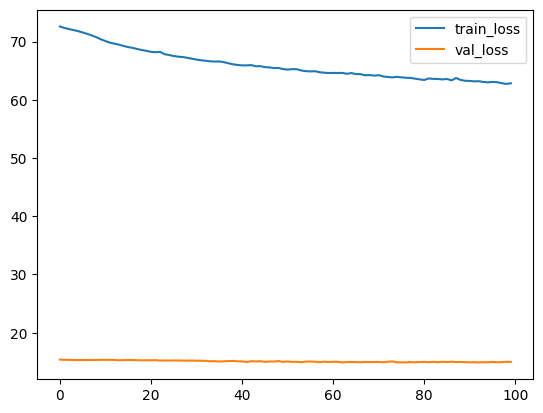

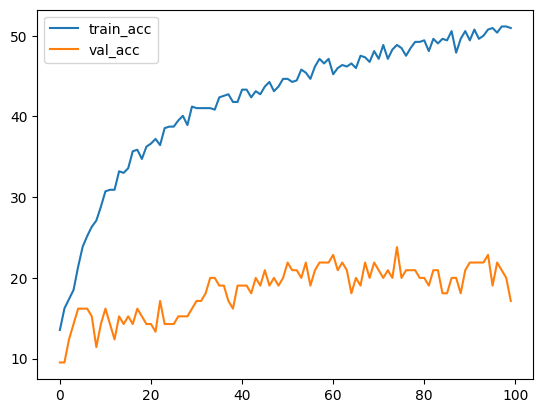

105 18

Accuracy: 17.14

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.59700655937195
Train Accuracy: 12.98%
Test loss: 15.429320812225342
Test Accuracy: 11.43%
Epoch 2, Trainloss: 72.21422815322876
Train Accuracy: 16.22%
Test loss: 15.403968334197998
Test Accuracy: 15.24%
Epoch 3, Trainloss: 71.97290253639221
Train Accuracy: 20.99%
Test loss: 15.383429527282715
Test Accuracy: 18.10%
Epoch 4, Trainloss: 71.74090504646301
Train Accuracy: 22.14%
Test loss: 15.371703386306763
Test Accuracy: 18.10%
Epoch 5, Trainloss: 71.49777173995972
Train Accuracy: 25.76%
Test loss: 15.367020845413208
Test Accuracy: 19.05%
Epoch 6, Trainloss: 71.24057126045227
Train Accuracy: 26.91%
Test loss: 15.343616724014282
Test Accuracy: 21.90%
Epoch 7, Trainloss: 71.02699875831604
Train Accuracy: 27.67%
Test loss: 15.31467080116272
Test Accuracy: 20.95%
Epoch 8, Trainloss: 70.80154037475586
Train Accuracy:

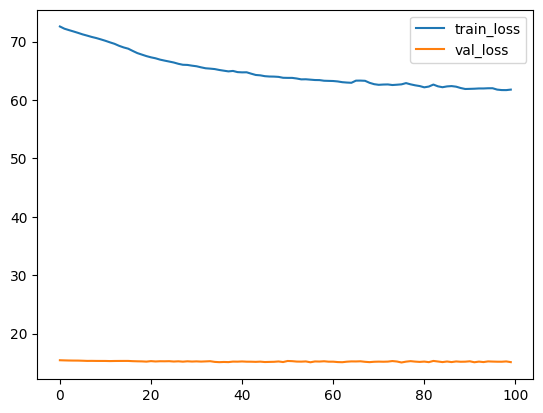

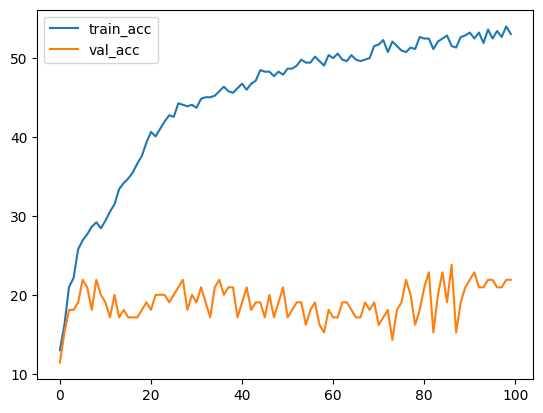

105 23

Accuracy: 21.90

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.54752445220947
Train Accuracy: 14.89%
Test loss: 15.349889516830444
Test Accuracy: 15.24%
Epoch 2, Trainloss: 72.09851264953613
Train Accuracy: 19.85%
Test loss: 15.300715923309326
Test Accuracy: 18.10%
Epoch 3, Trainloss: 71.7537636756897
Train Accuracy: 23.66%
Test loss: 15.225578546524048
Test Accuracy: 22.86%
Epoch 4, Trainloss: 71.40452837944031
Train Accuracy: 25.19%
Test loss: 15.163717031478882
Test Accuracy: 25.71%
Epoch 5, Trainloss: 71.04880118370056
Train Accuracy: 25.57%
Test loss: 15.13711953163147
Test Accuracy: 23.81%
Epoch 6, Trainloss: 70.8132495880127
Train Accuracy: 26.72%
Test loss: 15.105857133865356
Test Accuracy: 23.81%
Epoch 7, Trainloss: 70.62915062904358
Train Accuracy: 28.44%
Test loss: 15.085886716842651
Test Accuracy: 23.81%
Epoch 8, Trainloss: 70.42183566093445
Train Accuracy: 2

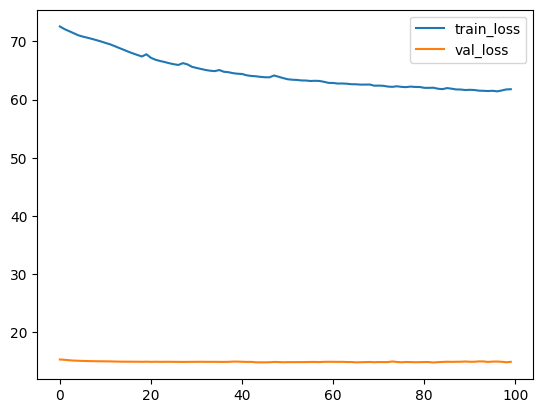

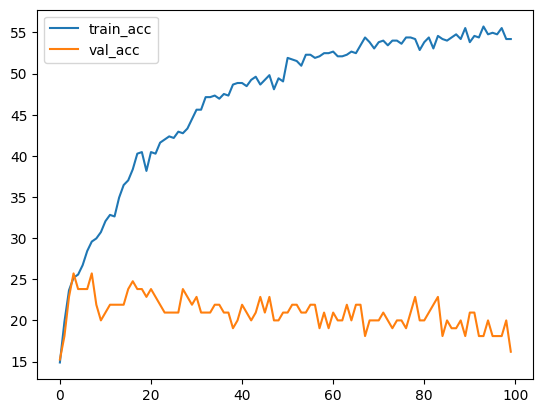

105 17

Accuracy: 16.19

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.55123519897461
Train Accuracy: 12.40%
Test loss: 15.393585681915283
Test Accuracy: 13.33%
Epoch 2, Trainloss: 72.3300530910492
Train Accuracy: 15.08%
Test loss: 15.350544691085815
Test Accuracy: 11.43%
Epoch 3, Trainloss: 72.15732526779175
Train Accuracy: 13.55%
Test loss: 15.284065961837769
Test Accuracy: 13.33%
Epoch 4, Trainloss: 71.98658871650696
Train Accuracy: 15.84%
Test loss: 15.30446743965149
Test Accuracy: 14.29%
Epoch 5, Trainloss: 71.76372337341309
Train Accuracy: 17.75%
Test loss: 15.244569778442383
Test Accuracy: 16.19%
Epoch 6, Trainloss: 71.58152318000793
Train Accuracy: 20.04%
Test loss: 15.208275079727173
Test Accuracy: 20.00%
Epoch 7, Trainloss: 71.38397598266602
Train Accuracy: 21.18%
Test loss: 15.226096868515015
Test Accuracy: 20.00%
Epoch 8, Trainloss: 71.16596961021423
Train Accuracy: 

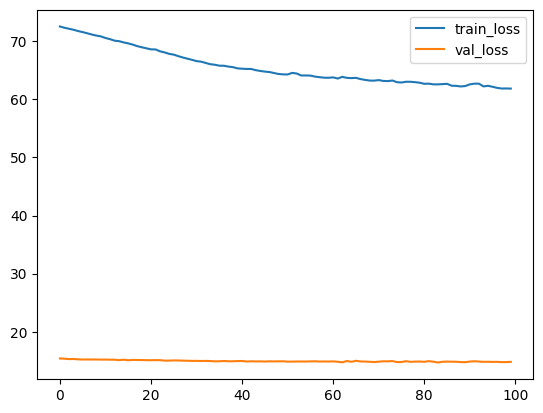

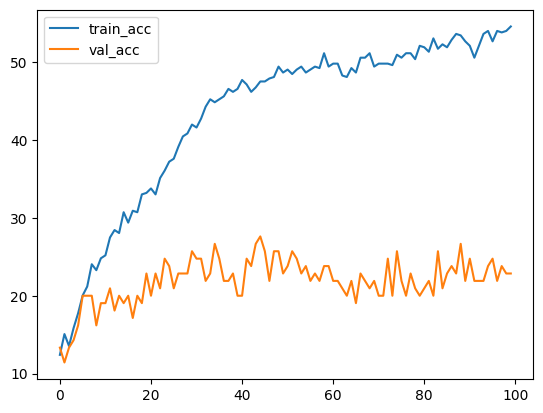

105 24

Accuracy: 22.86

Training Features Shape: (524, 49)
Training Labels Shape: (524, 9)
Testing Features Shape: (105, 49)
Testing Labels Shape: (105, 9)
Epoch 1, Trainloss: 72.40922546386719
Train Accuracy: 15.27%
Test loss: 15.366360187530518
Test Accuracy: 13.33%
Epoch 2, Trainloss: 72.19302582740784
Train Accuracy: 17.37%
Test loss: 15.306456327438354
Test Accuracy: 18.10%
Epoch 3, Trainloss: 71.97142314910889
Train Accuracy: 20.42%
Test loss: 15.262967109680176
Test Accuracy: 19.05%
Epoch 4, Trainloss: 71.7503445148468
Train Accuracy: 21.76%
Test loss: 15.250933408737183
Test Accuracy: 19.05%
Epoch 5, Trainloss: 71.64311861991882
Train Accuracy: 23.47%
Test loss: 15.229247331619263
Test Accuracy: 22.86%
Epoch 6, Trainloss: 71.44765210151672
Train Accuracy: 24.62%
Test loss: 15.200639724731445
Test Accuracy: 20.00%
Epoch 7, Trainloss: 71.23825693130493
Train Accuracy: 24.62%
Test loss: 15.214913368225098
Test Accuracy: 16.19%
Epoch 8, Trainloss: 71.00643610954285
Train Accuracy:

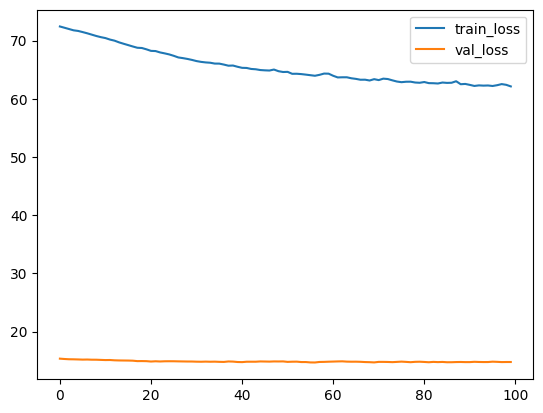

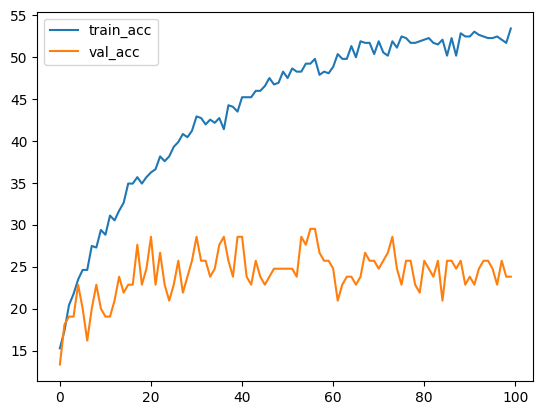

105 25

Accuracy: 23.81

Training Features Shape: (525, 49)
Training Labels Shape: (525, 9)
Testing Features Shape: (104, 49)
Testing Labels Shape: (104, 9)
Epoch 1, Trainloss: 72.57059359550476
Train Accuracy: 11.62%
Test loss: 15.410471677780151
Test Accuracy: 10.58%
Epoch 2, Trainloss: 72.29861831665039
Train Accuracy: 15.43%
Test loss: 15.360981702804565
Test Accuracy: 12.50%
Epoch 3, Trainloss: 72.04589056968689
Train Accuracy: 16.95%
Test loss: 15.312084913253784
Test Accuracy: 15.38%
Epoch 4, Trainloss: 71.8501205444336
Train Accuracy: 19.05%
Test loss: 15.291569232940674
Test Accuracy: 16.35%
Epoch 5, Trainloss: 71.67229700088501
Train Accuracy: 22.10%
Test loss: 15.270170450210571
Test Accuracy: 19.23%
Epoch 6, Trainloss: 71.49243140220642
Train Accuracy: 24.19%
Test loss: 15.250198602676392
Test Accuracy: 17.31%
Epoch 7, Trainloss: 71.31548261642456
Train Accuracy: 25.33%
Test loss: 15.228585720062256
Test Accuracy: 19.23%
Epoch 8, Trainloss: 71.12740659713745
Train Accuracy:

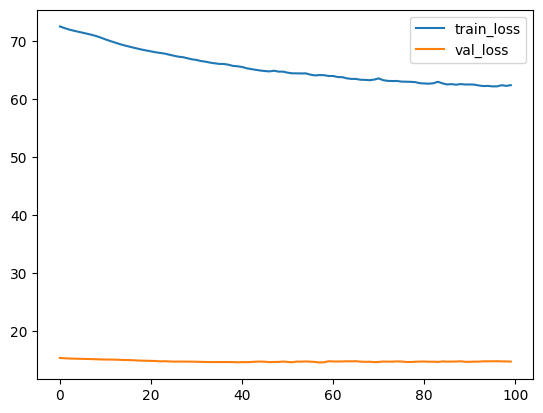

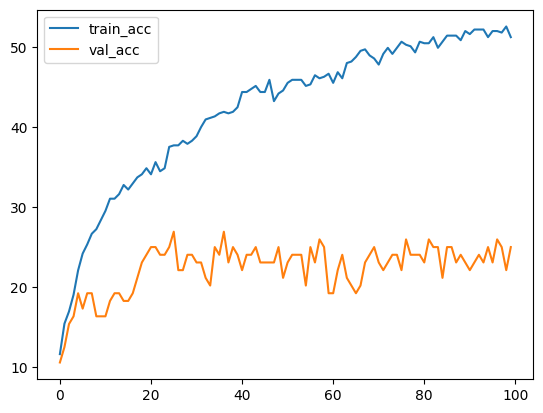

104 26

Accuracy: 25.00



In [235]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


feature_list = list(X.columns)

X = X.to_numpy()
y = y.to_numpy()
kf = KFold(n_splits=6)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, test_features = X[train_index], X[test_index]
    train_labels, test_labels = y[train_index], y[test_index]
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)

    train_dataset = TabularDataset(train_features, train_labels)

    train_loader = DataLoader(train_dataset, batch_size=16)

    test_dataset = TabularDataset(test_features, test_labels)

    test_loader = DataLoader(test_dataset, batch_size=16)

    model = Net(input_size=train_features.shape[1], hidden_size=10, num_classes=9)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)

    trainLosses = []
    testLosses = []
    trainAcc = []
    testAcc = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model,train_loader,epoch,criterion,optimizer)
        test_loss, test_acc = test(model,test_loader,criterion)
        trainLosses.append(train_loss)
        testLosses.append(test_loss)
        trainAcc.append(train_acc)
        testAcc.append(test_acc)
    plt.plot(trainLosses,label='train_loss')
    plt.plot(testLosses,label='val_loss')
    plt.legend()
    plt.show()
    plt.plot(trainAcc,label='train_acc')
    plt.plot(testAcc,label='val_acc')
    plt.legend()
    plt.show()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(dim=1)).sum().item() 
            
    print(total, correct)
    accuracy = 100 * (correct / total)
    print('\nAccuracy: {:.2f}\n'.format(accuracy))

 